# I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import fnmatch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
import random
import dcor
import re
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-03-26 14:08:21.208050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('All', 'Bona'), value='All')

# II. Load Data

In [6]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget


IndexError: list index out of range

In [ ]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

# Select only the columns you need as labels from df_properties
df_label = df_properties[['obsreg_id','hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
mask_nonan = df_label.notna().all(axis=1)
index_nonan = list(df_label.notna().all(axis=1).index[df_label.notna().all(axis=1)])
df_label = df_label[mask_nonan]
ID = df_label['obsreg_id'].values
XX = features[(index_nonan),:]
df_yy = df_label[['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
YY = df_yy.values
print(len(XX),len(YY))
# More filters to get reduced dataset
reduce = 1
df_label1 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label1 = df_label1.sample(n=round(len(df_label1)/reduce))
df_label2 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label2 = df_label2.sample(n=round(len(df_label2)/reduce))
df_label3 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label3 = df_label3.sample(n=round(len(df_label3)/reduce))
df_label4 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label4 = df_label4.sample(n=round(len(df_label4)/reduce))

df_label5 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label5 = df_label5.sample(n=round(len(df_label5)/reduce))
df_label6 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label6 = df_label6.sample(n=round(len(df_label6)/reduce))
df_label7 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label7 = df_label7.sample(n=round(len(df_label7)/reduce))
df_label8 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label8 = df_label8.sample(n=round(len(df_label8)/reduce))

df_label9 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label9 = df_label9.sample(n=round(len(df_label9)/reduce))
df_label10 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label10 = df_label10.sample(n=round(len(df_label10)/reduce))
df_label11 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label11 = df_label11.sample(n=round(len(df_label11)/reduce))
df_label12 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label12 = df_label12.sample(n=round(len(df_label12)/reduce))

df_label13 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label13 = df_label13.sample(n=round(len(df_label13)/reduce))
df_label14 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label14 = df_label14.sample(n=round(len(df_label14)/reduce))
df_label15 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label15 = df_label15.sample(n=round(len(df_label15)/reduce))
df_label16 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label16 = df_label16.sample(n=round(len(df_label16)/reduce))

print(len(df_label1),len(df_label2),len(df_label3),len(df_label4),len(df_label5),len(df_label6),len(df_label7),len(df_label8),len(df_label9),len(df_label10),len(df_label11),len(df_label12),len(df_label13),len(df_label14),len(df_label15),len(df_label16))
# More filters to get reduced dataset
df_final_label = pd.concat([df_label1,df_label2, df_label3, df_label4, df_label5, df_label6, df_label7, df_label8, df_label9, df_label10, df_label11, df_label12,df_label13,df_label14,df_label15,df_label16])
df_final_label = df_final_label.sort_values('obsreg_id')
index_final = list(df_final_label.index)
ID = df_final_label['obsreg_id'].values
X = features[(index_final),:]
# Scale the labels to the same range as the data
df_y = df_final_label[['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
Y = df_y.values
print('Length X:', len(X))
print('Length Y:', len(Y))
df_final_label.head()


Number of Features:  82283
Number of Property Sets:  82283
51830 51830
2919 15648 8189 1693 991 5970 3340 545 580 2796 1681 318 1649 2898 1741 872
Length X: 51830
Length Y: 51830


,obsreg_id,hard_hm,hard_hs,hard_ms,var_prob_b,var_prob_h,var_prob_m,var_prob_s
1,10004_1,0.398501,0.488445,0.094941,0.524820,0.127010,0.676527,0.485168
3,10025_72,0.058713,-0.103685,-0.162399,0.105254,0.252282,0.650681,0.283007
5,10026_72,0.148657,0.103685,-0.048720,0.102169,0.289265,0.587968,0.113789
11,10037_40,0.028732,0.338538,0.309806,0.119011,0.438140,0.236688,0.551795
15,10037_82,0.367270,0.808245,0.624610,0.074846,0.234351,0.141653,0.528878


# III. PCA Optimisation?

Elbow Point (36,6 -> 21 for 2D // 671,12 -> 341/2 (121,12 -> 66/67 for 0.005 and 0.9) ) for 0.005 and 0.95 (NOTE THIS IS ON THE 50000, not all) 

2D for all (0.005 knee, 0.95 var): Elbow point: 7
Number of components to retain 95% variance: 64
Avg: 35.5

3D for all (0.005 knee, 0.90 var): 

Elbow point: 7
Number of components to retain 95% variance: 7
Avg: 7.0


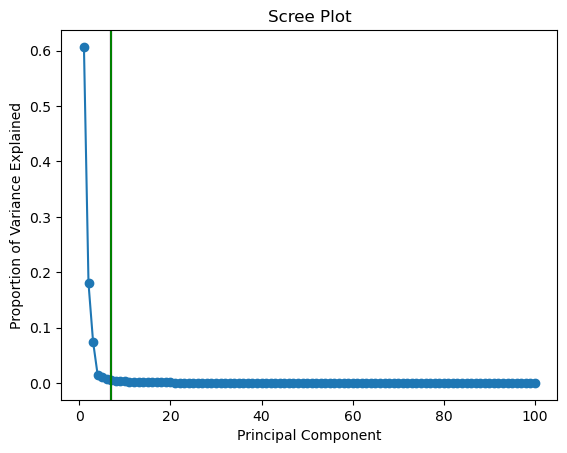

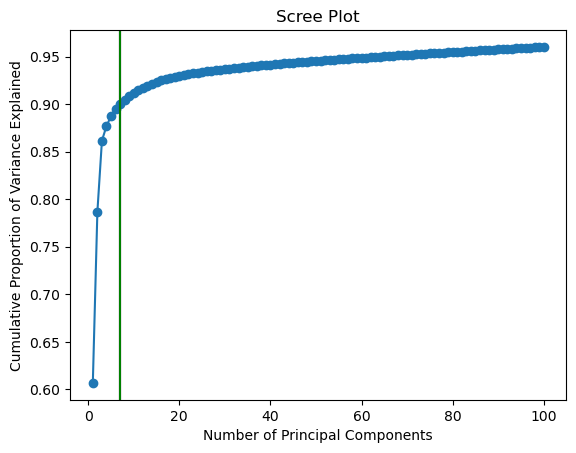

In [40]:
pca_model = PCA(100)
Xpca = pca_model.fit_transform(features) 

# identify the elbow point
cumulative_var = np.cumsum(pca_model.explained_variance_ratio_)
elbow_point = np.argmax(np.diff(cumulative_var) <= 0.005) + 1
n_components95 = np.argmax(cumulative_var >= 0.90) + 1
avg = (elbow_point  + n_components95)/2
print('Elbow point:', elbow_point)
print("Number of components to retain 95% variance:", n_components95)
print("Avg:", avg)

# plot the scree plot
ax1 = plt.plot(np.arange(1, pca_model.n_components_ + 1), pca_model.explained_variance_ratio_, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.grid(False) 
plt.axvline(x=elbow_point, color='r')
plt.axvline(x=n_components95, color='b')
plt.axvline(x=avg, color='g')
plt.show()


# plot the cumulative proportion of variance explained
ax2 = plt.plot(np.arange(1, pca_model.n_components_ + 1), np.cumsum(pca_model.explained_variance_ratio_), 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('Scree Plot')
plt.grid(False) 
plt.axvline(x=elbow_point, color='r')
plt.axvline(x=n_components95, color='b')
plt.axvline(x=avg, color='g')
plt.show()


Run PCA 

In [5]:
#Run PCA with chosen n
n_pca = 36
pca_model = PCA(n_pca)
pca_out = pca_model.fit_transform(XX) 
# Save PCA Output
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]
with open(f'{global_path}/{set_id}/pca-{set_id}-{data_rep}-PCA{n_pca}.pkl', 'wb') as f:
    pickle.dump(pca_out , f)


# III. TSNE Runs

In [4]:
# Load PCA Output
files = os.listdir(f'{global_path}/{set_id}/')
pca_files = [f for f in files if fnmatch.fnmatch(f, 'pca*36*')]
pca_widget = widgets.Dropdown(options=pca_files[:],value=pca_files[0],description='PCA File :',disabled=False); pca_widget

Dropdown(description='PCA File :', options=('pca-All-hist2D-All-nE16-nt24-normnone-PCA36.pkl',), value='pca-Al…

In [63]:
from pydub import AudioSegment
from pydub.playback import play
import math
import beepy as beep


pca_file = pca_widget.value
with open(f'{global_path}/{set_id}/{pca_file}', 'rb') as f:
    pca_out = pickle.load(f)
learning_rates = [25, 50, 75, 100, 125,150,175,200,225,250]
perplexities = [10,20,30,40,50,60,70,80,90,100]

with open(f'{global_path}/{set_id}/dY.pkl', 'rb') as f:
        dY = pickle.load(f)

performance_matrix1 = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix1p = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix2 = np.zeros((len(learning_rates), len(perplexities)))

# TSNE Setting
n_comp = 2
early_exag = 1
iterations = 2000
# Counter
total_count = len(learning_rates) * len(perplexities)
counter = 0
for lr_ix in range(len(learning_rates)):
    for perp_ix in range(4, len(perplexities)):
        learn_rate = learning_rates[lr_ix]
        perp = perplexities[perp_ix]
        # Define TSNE Model
        tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init='random')
        # Run TSNE Model on Data
        tsne_out = tsne_model.fit_transform(pca_out)
        print('TSNE Done')
        dX = pdist(tsne_out,'euclidean')
        print(dX.shape)
        print('pdist Done')
        # Save TSNE Output
        pca_rep = pca_file.split(".pkl")[0]
        with open(f'{global_path}/{set_id}/dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl', 'wb') as f:
            pickle.dump(dX, f)
        print(f'Saved as: dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl')
        beep.beep(sound=1)

# lr_ix = 9
# perp_ix = 3
# learn_rate = learning_rates[lr_ix]
# perp = perplexities[perp_ix]
# early_exag = 1
# iterations = 2000

# # Define TSNE Model
# tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init='random')
# # Run TSNE Model on Data
# tsne_out = tsne_model.fit_transform(pca_out)
# print('TSNE Done')
# dX = pdist(tsne_out,'euclidean')
# print(dX.shape)
# print('pdist Done')

# # Save TSNE Output
# pca_rep = pca_file.split(".pkl")[0]
# with open(f'{global_path}/{set_id}/dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl', 'wb') as f:
#     pickle.dump(dX, f)
# print(f'Saved as: dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl')
# beep.beep(sound=1)


TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,4)-All-hist2D-All-nE16-nt24-normnone-lr25-perp50.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,5)-All-hist2D-All-nE16-nt24-normnone-lr25-perp60.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,6)-All-hist2D-All-nE16-nt24-normnone-lr25-perp70.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,7)-All-hist2D-All-nE16-nt24-normnone-lr25-perp80.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,8)-All-hist2D-All-nE16-nt24-normnone-lr25-perp90.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(0,9)-All-hist2D-All-nE16-nt24-normnone-lr25-perp100.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(1,4)-All-hist2D-All-nE16-nt24-normnone-lr50-perp50.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(1,5)-All-hist2D-All-nE16-nt24-normnone-lr50-perp60.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(1,6)-All-hist2D-All-nE16-nt24-normnone-lr50-perp70.pkl
TSNE Done
(1343148535,)
pdist Done
Saved as: dX-(1,7)-All-hist2

OSError: [Errno 28] No space left on device

# III. TSNE Optimsation

In [5]:
files = os.listdir(f'{global_path}/{set_id}/')
dX_files = [f for f in files if fnmatch.fnmatch(f, 'dX-(*nE16*')]
dX_widget = widgets.SelectMultiple(options=dX_files[:],value=dX_files[:], description='dX Files : ', disabled=False); dX_widget

SelectMultiple(description='dX Files : ', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

Y distance...

In [1]:
# Compute the inverse covariance matrix
covariance_matrix = np.cov(YY, rowvar=False)
inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
# Compute the Mahalanobis distance matrix for X using pdist
dY = pdist(YY, 'mahalanobis', VI=inverse_covariance_matrix)
print(dY.shape)

with open(f'{global_path}/{set_id}/dY.pkl', 'wb') as f:
    pickle.dump(dY, f)


NameError: name 'np' is not defined

In [7]:
# Load the DataFrame from the CSV file
learning_rates = [25, 50, 75, 100, 125]#,150,175,200,225,250]
perplexities = [10,20,30,40,50,60]#,70,80,90,100]

total_count = len(learning_rates) * len(perplexities)
counter = 0

with open(f'{global_path}/{set_id}/dY.pkl', 'rb') as f:
        dY = pickle.load(f)

performance_matrix1 = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix1p = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix2 = np.zeros((len(learning_rates), len(perplexities)))

dX_files = sorted(dX_widget.value)
for dX_file in dX_files:
    print(dX_file)
    with open(f'{global_path}/{set_id}/{dX_file}', 'rb') as f:
        dX = pickle.load(f)
    # Define a regular expression pattern to match "(A,B)"
    pattern = r"\((\d+),(\d+)\)"
    match = re.search(pattern, dX_file)
    i = match.group(1)
    j = match.group(2)
    # Performance
    performance_metric1, p1 = spearmanr(dX,dY)
    performance_metric2 = dcor.distance_correlation(dX,dY)

    performance_matrix1[i,j] = performance_metric1 
    performance_matrix1p[i,j] = p1
    performance_matrix2[i,j] = performance_metric2 

    print(performance_metric1,p1,performance_metric2)

    counter = counter+1
    clear_output(wait=True)
    print(f'Counter: {counter} of {total_count}')
    print(f'DONE!!!')

    # Save TSNE Output
    pca_rep = pca_file.split(".pkl")[0]
    with open(f'{global_path}/{set_id}/performance1-{set_id}-{pca_rep}-lr({i})-pp({j})-2D.pkl', 'wb') as f:
        pickle.dump(performance_matrix1, f)
    with open(f'{global_path}/{set_id}/performance1p-{set_id}-{pca_rep}-lr({i})-pp({j})-2D.pkl', 'wb') as f:
        pickle.dump(performance_matrix1p, f)
    with open(f'{global_path}/{set_id}/performance2-{set_id}-{pca_rep}-lr({i})-pp({j})-2D.pkl', 'wb') as f:
        pickle.dump(performance_matrix2, f)


dX-(0,0)-All-hist2D-All-nE16-nt24-normnone-lr25-perp10.pkl


EOFError: Ran out of input

In [ ]:
# Select Performance Matrix
files = os.listdir(f'{global_path}/{set_id}/')
perf_files = [f for f in files if fnmatch.fnmatch(f, 'perfmatrix*none*.pkl')]
perf_widget = widgets.Dropdown(options=perf_files[:],value=perf_files[0],description='Performance Matrix :',disabled=False); perf_widget

In [ ]:
# load the matrix from the file
perf_string = perf_widget.value
parts_string = perf_string .split('-')
lr = 'learn-' + '-'.join(parts_string[1:])
perp = 'perp-' + '-'.join(parts_string[1:])
with open(f'{global_path}/{set_id}/{perf_string }', 'rb') as f:
    performance_matrix = pickle.load(f)
with open(f'{global_path}/{set_id}/{lr}', 'rb') as f:
    learning_rates = pickle.load(f)
with open(f'{global_path}/{set_id}/{perp}', 'rb') as f:
    perplexities = pickle.load(f)

fig, ax = plt.subplots()
# Define Font Settings
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"

im = ax.imshow(performance_matrix, cmap='Spectral')
ax.set_yticks(np.arange(len(learning_rates)),labels = learning_rates)
ax.set_ylabel('learning_rate')
ax.set_xticks(np.arange(len(perplexities)), labels = perplexities)
ax.set_xlabel('perplexity')
ax.grid(False) 

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("performance_metric")
# Loop over data dimensions and create text annotations.
for i in range(len(learning_rates)):
    for j in range(len(perplexities)):
        text = ax.text(j, i, round(performance_matrix[i, j],2),
                       ha="center", va="center", color="w")
        